In [212]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar
from scipy import stats

In [26]:
def process(y0, T, func, *args):
    """Feed me starting values, a differential equation like `lambda y_t, dt, dw[, ..]`
    and a list of driving processes and I return your proces"""
    l = len(args[0])
    Y = np.ones(l+1)*y0
    for i, dargs in enumerate(zip(*args)):
        Y[i+1] = Y[i] + func(Y[i], T/l, *dargs)
    return Y

## Pricing with stochastic volatility

In [195]:
N = 1000#int(1e4)
W = np.random.normal(size=(N, 3))/np.sqrt(N)
Wr = np.random.normal(size=(N,))/np.sqrt(N)
sS, sV, snu = np.random.uniform(size=(3,3))
xi = .04
k = np.inner(snu, snu)/xi*2
qV = .01
qS = .005

nu = process(.04, T, lambda nu, dt, dw: k*(xi-nu)*dt + np.sqrt(nu)*snu@dw, W)
r = process(.04, T, lambda r, dt, dw: 2*(1-r/.04)*dt + np.sqrt(r)*dw, Wr)
V = process(1, T, lambda v, dt, dw, nu, rt: v*(rt + qV)*dt + v*np.sqrt(nu)*sV@dw, W, nu, r)
S = process(1, T, lambda s, dt, dw, nu, rt: s*(rt + qS)*dt + s*np.sqrt(nu)*sS@dw, W, nu, r)

In [216]:
def simulate_set(W, Wr, T):
    nu = process(.04, T, lambda nu, dt, dw: k*(xi-nu)*dt + np.sqrt(nu)*snu@dw, W)
    r = process(.04, T, lambda r, dt, dw: 2*(1-r/.04)*dt + np.sqrt(r)*dw, Wr)
#     V = process(1, T, lambda v, dt, dw, nu, rt: v*(rt + qV)*dt + v*np.sqrt(nu)*sV@dw, W, nu, r)
    S = process(1, T, lambda s, dt, dw, nu, rt: s*(rt + qS)*dt + s*np.sqrt(nu)*sS@dw, W, nu, r)
    M = np.exp(np.cumsum(r*T/len(W))[1:] + (.2*sS + .2*sV + snu) @ W.T)
#     return nu, r, S, V
    return S[1:]*M

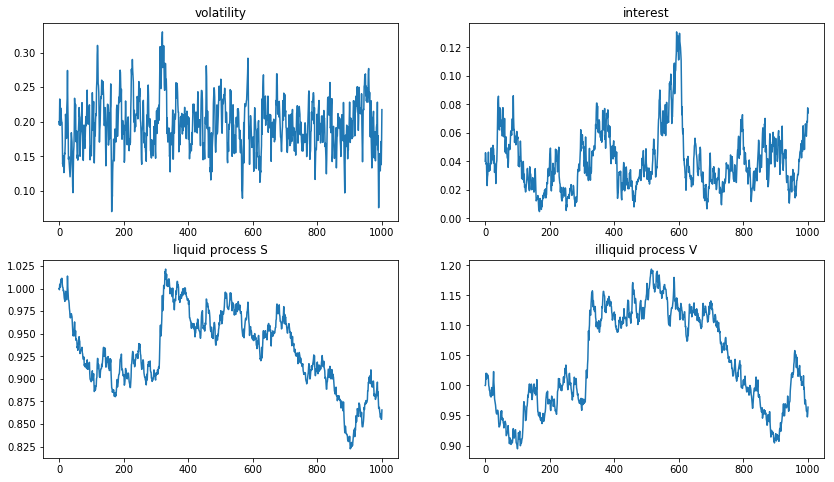

In [178]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2, figsize=(14,8))
ax11.plot(np.sqrt(nu)) ; ax11.set_title('volatility')
ax12.plot(r)           ; ax12.set_title('interest')
ax21.plot(S)           ; ax21.set_title('liquid process S')
ax22.plot(V)           ; ax22.set_title('illiquid process V');

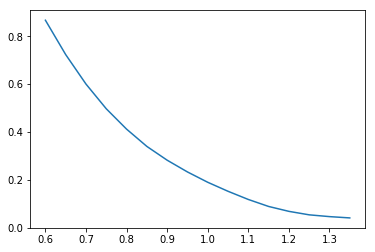

In [217]:
Y = np.zeros(len(K))
N = 10000
P = 20
samples = [
    simulate_set(
        np.random.normal(size=(N,3))/np.sqrt(N),
        np.random.normal(size=(N,))/np.sqrt(N),
        1
    )
    for _ in range(P)
]
for i, kk in enumerate(K):
    Y[i] = np.mean(np.maximum(
        0,
        [
            sample[-1] / kk - 1
            for sample in samples
        ]
    ))

plt.plot(K, Y)

In [218]:
def C(ks, cs, t, r):
    def blep(sigma):
        d1 = ( sigma/2 + r/sigma )*np.sqrt(t) - np.log(ks)/np.sqrt(t)/sigma
        return ( stats.norm.cdf(d1) - ks*np.exp(-r*t)*stats.norm.cdf(d1-sigma*np.sqrt(t)) - cs )**2
    return blep
imp_S = [
    minimize_scalar(C(ks, cs, 1, .04), method='bounded', bounds=[0,1]).x
    for ks, cs in zip(K, Y)
]

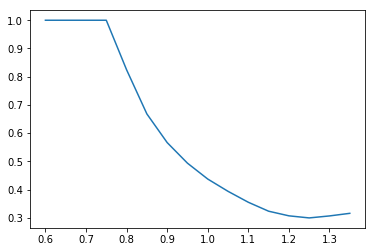

In [219]:
plt.plot(K, imp_S)

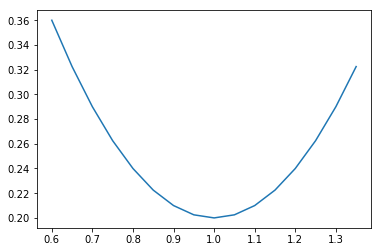

In [80]:
K = np.arange(.6, 1.4, .05)
S = np.apply_along_axis(lambda k: .2+(k-1)**2, 0, K)
plt.plot(K, S)

# Price bounds induced by different methods

In [5]:
N = int(1e6)
X = np.arange(0, 1, .01)
Y = np.zeros(shape=(len(X), 2))
W = np.random.normal(size=(3, N))

bar = lambda k,x: np.sqrt(k**2 - x**2)

p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15

### varying the correlation

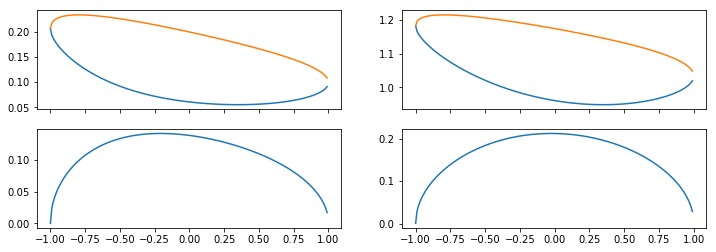

In [7]:
p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15
X = np.arange(-1, 1, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for r, YFi, YVi in zip(X, YF, YV):
    gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    gamma_ub = + np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    
    sigmaM_lb = np.array([qS/sS, gamma_lb, 0])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub, 0])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaV = np.array([sV*r, sV*bar(1,r), 0])
    muV = -qV -.5 * sigmaV @ sigmaV.T

#     sigmaS = np.array([sS, 0, 0])
#     muS = -qS -.5 * sigmaS @ sigmaS.T
    
#     S = np.exp(muS + sigmaS @ W)
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])
# print('F:  ', np.mean(F), '\nV:  ', np.mean(V), '\nM:  ', np.mean(M),
#       '\nMV: ', np.mean(M*V), '\nS:  ', np.mean(S), '\nMS: ', np.mean(M*S))

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the unobserved return process

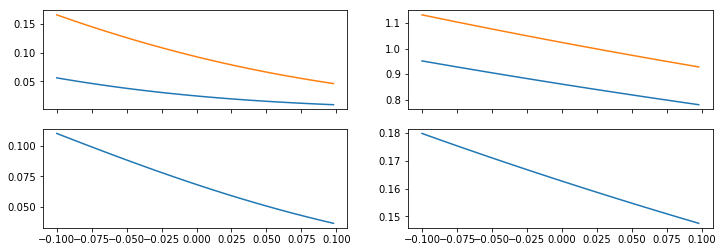

In [12]:
p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15
X = np.arange(qS, -qS, .001)*2
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for qV, YFi, YVi in zip(X, YF, YV):
    gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    gamma_ub = + np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    
    sigmaM_lb = np.array([qS/sS, gamma_lb, 0])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub, 0])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaV = np.array([sV*r, sV*bar(1,r), 0])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the unobserved volatility process

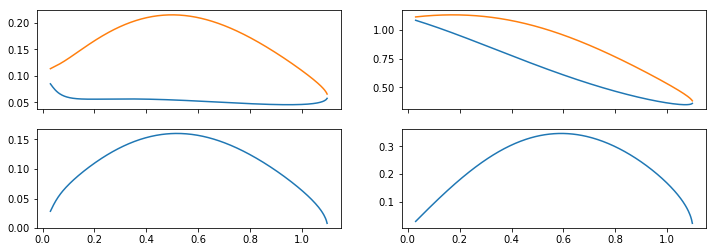

In [13]:
p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15
X = np.arange(.2*sS, (Sh - qS) / r, sS/50)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for sV, YFi, YVi in zip(X, YF, YV):
    gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    gamma_ub = + np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    
    sigmaM_lb = np.array([qS/sS, gamma_lb, 0])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub, 0])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaV = np.array([sV*r, sV*bar(1,r), 0])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the strike

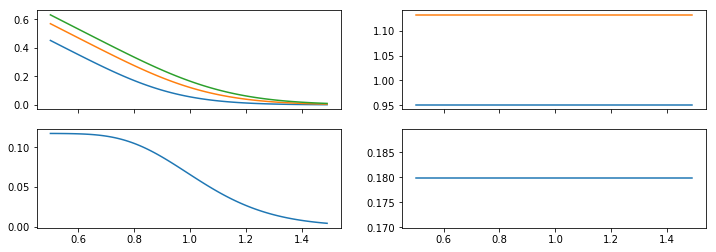

In [20]:
p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15
X = np.arange(.5,1.5,.01)
YF = np.zeros((len(X), 3))

gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
gamma_ub = + np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV

sigmaM_lb = np.array([qS/sS, gamma_lb, 0])
muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

sigmaM_ub = np.array([qS/sS, gamma_ub, 0])
muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

sigmaM = np.array([qS/sS, 0, 0])
muM = -.5 * sigmaM @ sigmaM.T

sigmaV = np.array([sV*r, sV*bar(1,r), 0])
muV = -qV -.5 * sigmaV @ sigmaV.T
    
V = np.exp(muV + sigmaV @ W)
M_lb = np.exp(muM_lb + sigmaM_lb @ W)
M_ub = np.exp(muM_ub + sigmaM_ub @ W)
M = np.exp(muM + sigmaM @ W)

for k, YFi in zip(X, YF):
    F = np.maximum(0, V-k)
    YFi += np.array([np.mean(M_lb*F), np.mean(M*F), np.mean(M_ub*F)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the sharpe ratio limit

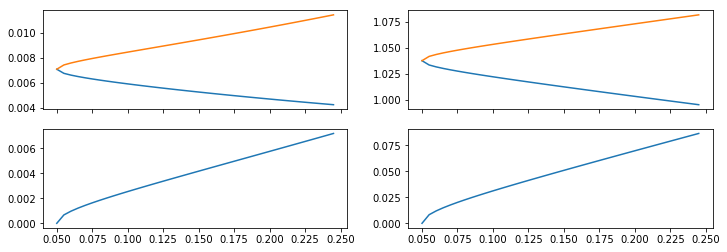

In [15]:
p = .9
Sh= .5
r = .5
qS = -.05
qV = -.1
sV = .2
sS = .15
X = np.arange(r*sV + qS, (r*sV + qS)*5, (r*sV + qS)/10)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for Sh, YFi, YVi in zip(X, YF, YV):
    gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    gamma_ub = + np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV
    
    sigmaM_lb = np.array([qS/sS, gamma_lb, 0])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub, 0])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaV = np.array([sV*r, sV*bar(1,r), 0])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-k)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

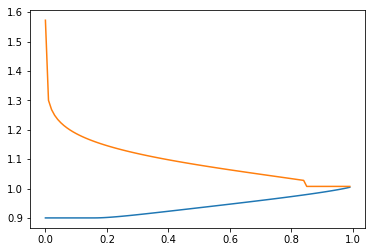

In [223]:
for p, yi in zip(X, Y):
    x = np.maximum(k, np.exp(mux + sigmax @ W))
    #percentile bounds
    yi += np.mean(x[x <= np.percentile(x, 100*p)]), np.mean(x[-x <= np.percentile(-x, 100*p)])

plt.plot(X,Y)

In [155]:
w = np.random.normal(size=(int(1e7),))
mx, sx = 1,.02 
sm = .6
mm = 0
p = .1
x = np.exp(mx + sx*w)
m = np.exp(mm + sm*w)
# ESl = np.mean(x[x <= np.percentile(x, 100*p)])
ESu = np.mean(x[-x <= np.percentile(-x, 100*p)])
ESm = np.mean((x*m)[-x*m <= np.percentile(-x*m, 100*p)])
smb = np.sqrt((np.log(ESu)-mx)*2)-sx
print(f'''{ESl:9.5f}
{ESu:9.5f}
{ESm:9.5f}
{np.mean(m*x):9.5f}

{np.exp(mm+mx+(sm+sx)**2/2):9.5f}
{-np.percentile(-x, 100*p):9.5f}
{smb:9.5f}
''')

  2.62458
  2.81546
  8.37029
  3.29338

  3.29432
  2.78880
  0.24505



In [177]:
import progressbar
bar = progressbar.ProgressBar()

w = np.random.normal(size=(int(1e6),))

X = np.arange(.1, 5,.1)
Y = np.zeros((len(X), 4))
mx, sx = 0,.02 
p = .001

for i, sx in enumerate(X):
    x = np.exp(mx + sx*w)
    ESx = np.mean(x[-x <= np.percentile(-x, 100*p)])
    f = np.maximum(x - np.exp(mx + sx**2/2), 0)
    ESf = np.mean(f[-f <= np.percentile(-f, 100*p)])
    Y[i] = ESx, ESf, np.sqrt((np.log(ESx)-mx)*2)-sx, 0


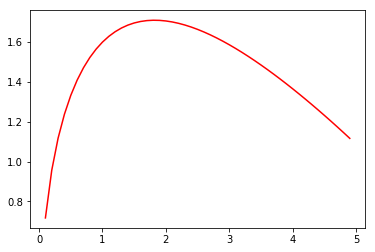

In [178]:
plt.plot(X,Y[:,2], 'r')

# plt.plot(X, np.power(X,1/3), 'k')